# Project Milestone 2 Pipeline

Our pipeline has the following 4 major parts: 
##### 1. Data cleaning and data quality analysis
##### 2. Movie releases and genre over time 
##### 3. Historical events scraping and plot analysis 
##### 4. Historical events and genre analysis 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from enum import Enum
import json

In [3]:
class Data(Enum):
    MOVIES = "movie.metadata.tsv"
    PLOTS = "plot_summaries.txt"
    NAME_CLUSTERS = "name.clusters.txt"
    EVENTS = "AnnotatedListOfEvents.json"

def load_data(type : Data, columns, index_col = ""):
    """
    Loads data of type using the Data Enum, with columns, and index_col as the index if provided. The data must be in a folder named MovieSummaries.

    returns: DataFrame
    """
    return pd.read_csv(
        f'./rawdata/MovieSummaries/{type.value}', 
        sep="\t", 
        names=columns,
        index_col=index_col if index_col != "" else columns[0]
    )

def load_events(): 
    """
    Loads the events data from json

    returns: a list of event objects (name, date, link)
    """
    f = open('AnnotatedListOfEvents.json')
    event_data = json.load(f)['events']
    return event_data


orig_movie_df = load_data(
    Data.MOVIES, 
    ["wiki_id", "freebase_id", "name", "release_date", "revenue", "runtime", "languages", "countries", "genres"],
)
plot_df = load_data(
    Data.PLOTS, 
    ["wiki_id", "plot"]
)
name_df = load_data(
    Data.NAME_CLUSTERS, 
    ["character_name", "freebase_id"],
    index_col="freebase_id"
)
event_data = load_events()


## Data Cleaning
Here we match the movies metadata with the plot summaries, and clean out unnecessary punctuations, parse strings into separate and processable values, use appropriate datatypes etc. 

In [4]:
def parse_multi_values(x): 
    """
    Parses the multi value structure of the dataset format into a sorted array of items
    Returns null values for empty lists as NaN (so all missing values we use are NaN)
    
    returns: array of strings extracted from x
    """
    if not x: 
        return []
    x = x.split(',')
    result = []
    for combo in x: 
        combo = combo.split(":")
        if len(combo) > 1: 
            combo[1] = re.sub("[^a-zA-Z0-9\s]+", "", combo[1])
            combo[1] = re.sub("^\s", "", combo[1])
            combo[1] = combo[1].strip()
            result.append(combo[1])
    if not result:
        return []
    return sorted(result)

def parse_language(languages):
    """
    Parses the language column specifically by removing "Langauge" from each entry

    returns: list of strings of the languages
    """
    if not languages or type(languages) != list:
        return []
    return list(map(lambda l : l.replace("Language", "").strip(), languages))

def parse_date(x):
    """
    Parses the date format into an int representing only the year. Values with missing entries are given NaN.

    returns: string representing the year 
    """
    if not x or x == np.nan:
        return np.NaN
    return str(x).split("-")[0]

def remove_outliers(df : pd.DataFrame):
    """
    Since we are interested in how movies change over time, we are removing all the values without release_date 
    and we also remove an outlier from 1010 and year 2015 since it's not a full year (it ends in March)

    returns: same dateframe df but with outliers removed
    """
    df = df[df['release_date'] != 'nan']
    df = df[df['release_date'] != '1010']
    df = df[df['release_date'] != '2013']
    df = df[df['release_date'] != '2014']
    df = df[df['release_date'] != '2015']
    df = df[df['release_date'] != '2016']
    return df

def data_clean_movies(df):
    # Add plot summaries to the movie dataframe
    df = df.join(plot_df)

    # Parse multi value attributes into arrays
    for attribute in ["languages", "countries", "genres"]:
        df[attribute] = df[attribute].apply(parse_multi_values)

    # Remove "Language" from language column
    df["languages"] = df["languages"].apply(parse_language)

    # Parse release-date to all use the year as an int (don't need increased granularity right now)
    df["release_date"] = df["release_date"].apply(parse_date)

    # Remove certain outliers 
    df = remove_outliers(df)

    # Replace missing numeric values with zero and convert to int rather than float
    for col in ["runtime", "revenue", "release_date"]:
        df[col] = df[col].fillna(0)
        df[col] = df[col].astype(int)
    
    return df

# Create df that is cleaned
movie_df = data_clean_movies(orig_movie_df)

# Display the head to get a sense for the data
display(movie_df.head(10))

,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,plot
wiki_id,,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001,14010832,98,[English],[United States of America],"[Action, Adventure, Horror, Science Fiction, S...","Set in the second half of the 22nd century, th..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,0,95,[English],[United States of America],"[Biographical film, Crime Drama, Drama, Mystery]",NaN
28463795,/m/0crgdbh,Brun bitter,1988,0,83,[Norwegian],[Norway],"[Crime Fiction, Drama]",NaN
9363483,/m/0285_cd,White Of The Eye,1987,0,110,[English],[United Kingdom],"[Erotic thriller, Psychological thriller, Thri...",A series of murders of rich young women throug...
261236,/m/01mrr1,A Woman in Flames,1983,0,106,[German],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra..."
13696889,/m/03cfc81,The Gangsters,1913,0,35,"[English, Silent film]",[United States of America],"[Blackandwhite, Comedy, Indie, Short Film, Sil...",NaN
18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,0,86,[English],[South Africa],"[Adventure, Family Film, Fantasy, World cinema]","Every hundred years, the evil Morgana returns..."
10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000,106,[English],[United States of America],"[Blackandwhite, Comedy, Musical]",NaN
9997961,/m/06_y2j7,Contigo y aquí,1974,0,0,[Spanish],[Argentina],"[Comedy, Drama, Musical]",NaN


### Analyzing missing values
Here we have a rough idea of the quality of the data, where we realized the genre data is relatively complete among the dataset. 

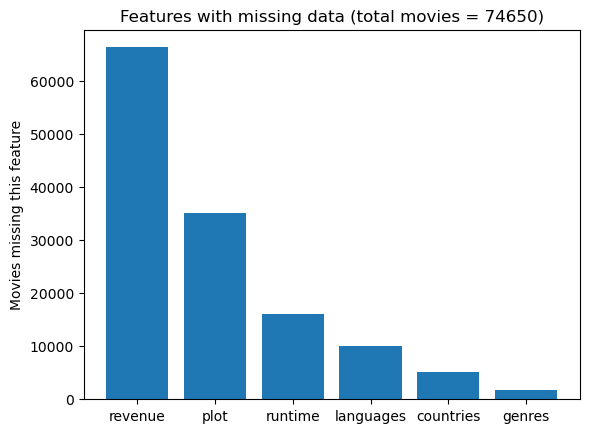

Rows without any missing data is 39511


In [5]:
def analyze_missing_values(df : pd.DataFrame): 
    """
    Checks to what extent we have missing data. For each column, count the number of missing data and plot a bar graph.
    """

    # Dictionary from col to missing values count 
    missing = {}
    for col in df.columns:
        # Missing are na or empty falsy values such as empty lists
        num_missing = df[col].isna().sum() + (df[col].astype(bool) == False).sum()
        if num_missing > 0:
            missing[col] = num_missing
    missing = sorted(missing.items(), key=lambda x: x[1], reverse=True)
    plt.bar(
        list(map(lambda x : x[0], missing)), 
        list(map(lambda x : x[1], missing)),
    )
    plt.title("Features with missing data (total movies = " + str(df.shape[0]) + ")")
    plt.ylabel("Movies missing this feature")
    plt.show()

    # Count how many rows are without any missing values
    non_missing = (df.notnull().all(axis="columns") == True).sum()
    print("Rows without any missing data is", non_missing)

analyze_missing_values(movie_df)

## Data Analysis Part 1: movie releases and genre over time 
### How many movies are released per year? 
It's obvious to see from the graph beneath the the number of movies has increased significantly since 2005, with over 1500 movies released per year

number_by_year is  release_date
1888       1
1889       1
1890       2
1891       3
1892       3
        ... 
2008    2465
2009    2247
2010    2022
2011    1824
2012    1194
Name: name, Length: 125, dtype: int64
years is  125


Text(0.5, 1.0, 'The number of movies released by year')

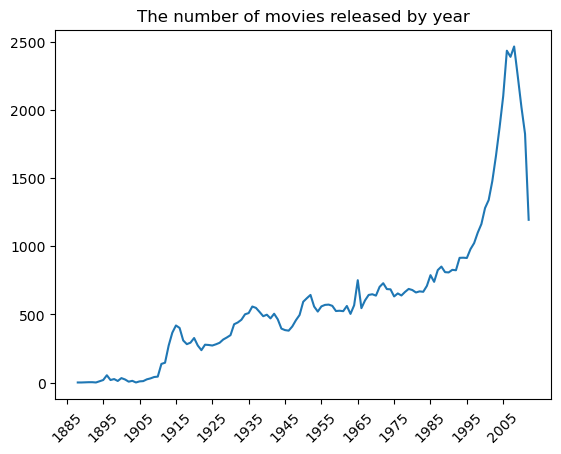

In [6]:
number_by_year = movie_df.groupby('release_date')['name'].count()
print("number_by_year is ", number_by_year)
years = list(range(1888, 2013, 1))
print("years is ", len(years))

fig, ax = plt.subplots()
ax.plot(years, number_by_year.values)
plt.xticks(np.arange(1885, 2015, 10), rotation = 45) 
plt.title("The number of movies released by year")

In [7]:
print(number_by_year[-15:-1])

release_date
1998    1100
1999    1163
2000    1280
2001    1339
2002    1478
2003    1662
2004    1872
2005    2102
2006    2434
2007    2389
2008    2465
2009    2247
2010    2022
2011    1824
Name: name, dtype: int64


### How does the frequency of genres change over time? 
* First, we cleaned up the genre cateogries into broader, more generalizable categories. 
  * a few examples of the cleaning efforts "biographical film" is shortened to "biographical", "actionadventure" is split into "action" and "adventure", and "romance" is combined with "romantic" 
* Then, we observe the number of films of certain genre released over time

,release_date,genre_divided
wiki_id,,
975900,2001,"[supernatural, thriller, science, horror, fict..."
3196793,2000,"[biographical, crime, drama, mystery]"
28463795,1988,"[crime, drama, fiction]"
9363483,1987,"[thriller, erotic, psychological]"
261236,1983,[drama]
13696889,1913,"[comedy, indie, short, blackandwhite, silent]"
18998739,2002,"[world, family, adventure, fantasy]"
10408933,1938,"[comedy, blackandwhite, musical]"
9997961,1974,"[comedy, drama, musical]"


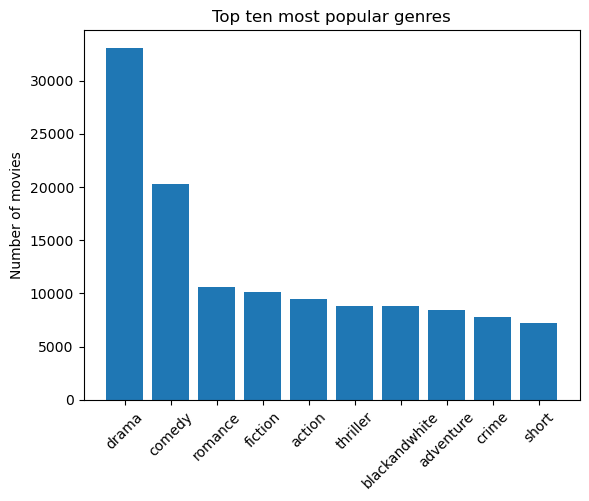

In [8]:
def combine_lists(elements):
    """
    Separate a word like "pyschological thriller" to "psychological" and "thriller"

    returns: list
    """
    result = []
    for x in elements: 
        result += x
    return result

def to_1D(series):
    """
    Maps a list of items in a series.

    returns: pd.Series 
    """
    return pd.Series([x for _list in series for x in _list])
    
movie_df['genre_divided'] = movie_df['genres'].apply(lambda x: [word.lower().split(" ") for word in x]).apply(combine_lists)

def remove_certain_genre(l):
    """
    Removes certain meaningless keywords from genre like "film" and "movies"
    Removes repeated words by changing to set; 
    if a film is ["romatic comedy", "dark comedy"], it would become ["romatic", "dark", "comedy"]

    returns: filtered list
    """
    no_meaning_words = {"film", "movies", "of", "movie", "cinema"}
    l = set(l)
    for word in no_meaning_words:
        if word in l: 
            l.remove(word)
    return list(l)

def swap_certain_genre (l):
    """
    Swaps words in listA to the list in listB. E.g., "romantic" is equal to "romance", and "actionadventure" is equal to "action" + "adventure"

    returns: list of swapped words
    """
    listA = ['romantic', 'actionadventure', 'comedydrama', 'childrensfamily']
    listB = [['romance'], ['action', 'adventure'], ['comedy', 'drama'], ['childrens', 'family']]
    for word in l:
        if word in listA: 
            ind = listA.index(word)
            l.remove(word)
            l += listB[ind]
    return list(set(l))

movie_df['genre_divided'] = movie_df['genre_divided'].apply(remove_certain_genre)
movie_df['genre_divided'] = movie_df['genre_divided'].apply(swap_certain_genre)
display(movie_df[['release_date', 'genre_divided']].head(10)) 

# Focus on the top 10 genres, as the ones beneath have less data 
# This filters out genres that might be interesting to analyze at a later stage like science fiction, animation and documentary. 
top_ten_list = to_1D(movie_df['genre_divided']).value_counts()[0:10]

# Let's do a bar plot to get a sense of the distribution of genres
plt.bar(
    top_ten_list.index, 
    top_ten_list.values,
)
plt.title("Top ten most popular genres")
plt.ylabel("Number of movies")
plt.xticks(rotation = 45)
plt.show()

#### How many films of the top ten genres are made per year? 

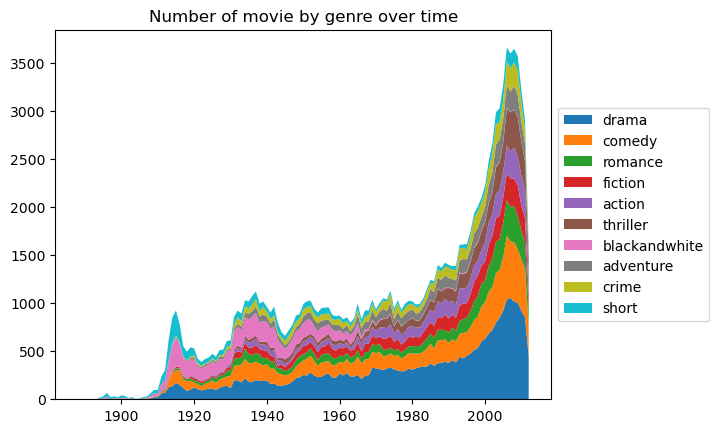

<AxesSubplot:title={'center':'Number of movie by genre over time'}>

In [9]:
def plot_stack_plot(df, labels, xaxis, title): 
    """
    Plots a stackplot.
    """
    vstack = []
    for genre in labels: 
        vstack.append(list(df[genre]))

    vstack = np.vstack(vstack)
    fig, ax = plt.subplots()
    ax.stackplot(xaxis, vstack, labels=labels)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.show()
    return ax

# Prepare new dataframe for plotting 
stackplot_df = movie_df[['release_date', 'genre_divided']].copy()
top_ten_genres = top_ten_list.index
for genre in top_ten_genres: 
    stackplot_df[genre] = 0

for genre in top_ten_genres:
    stackplot_df[genre] = stackplot_df['genre_divided'].apply(lambda x: 1 if genre in x else 0)

grouped_by = stackplot_df.groupby(by='release_date').sum().reset_index()
years = list(range(1888, 2013, 1))
plot_stack_plot(
    grouped_by, 
    top_ten_genres, 
    years, 
    'Number of movie by genre over time'
)

#### Normalized genres 
We realize that the above result might be affected by the number of labels it has. For example, a movie as ["comedy", "romance", and "blackandwhite" ] would contribute more to the graph by having each of those genres added. Therefore, we normalized the result by weighing each genre so they contribute equally. For instance, comedy, romance, and blankandwhite would each contribute 0.33 to the overall count.

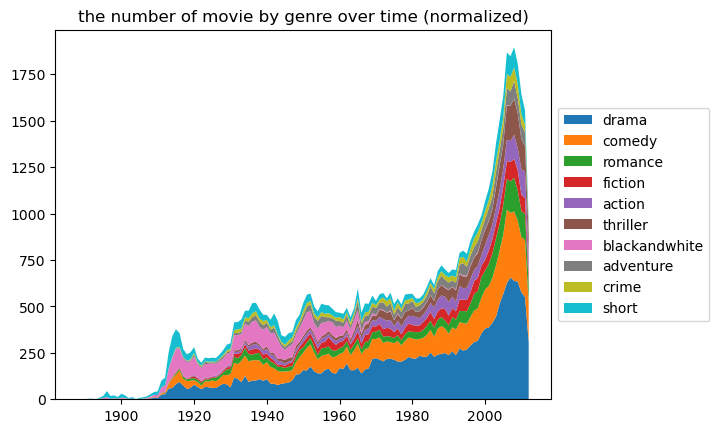

<AxesSubplot:title={'center':'the number of movie by genre over time (normalized)'}>

In [10]:
normalized_stack_df = stackplot_df.copy()
normalized_stack_df["sum"] = normalized_stack_df.iloc[:, 2:12].sum(axis=1)
for genre in top_ten_genres:
    normalized_stack_df[genre] = normalized_stack_df[genre] / normalized_stack_df['sum']

normalized_group_by = normalized_stack_df.groupby(by='release_date').sum().reset_index()
plot_stack_plot(normalized_group_by, top_ten_genres, years, "the number of movie by genre over time (normalized)")

#### Genre change in terms of percentage 
Let's look at how the popularity of genres have changed over time. 

,release_date,drama,comedy,romance,fiction,action,thriller,blackandwhite,adventure,crime,short,sum
120,2008,0.278478,0.168675,0.104326,0.078587,0.088171,0.107338,0.000548,0.068182,0.065717,0.039978,3652
121,2009,0.281477,0.155568,0.095971,0.091214,0.083380,0.115557,0.000839,0.063514,0.071349,0.041130,3574
122,2010,0.286557,0.165477,0.093449,0.079478,0.097175,0.108662,0.000000,0.066439,0.060230,0.042533,3221
123,2011,0.294178,0.174991,0.097485,0.083707,0.106786,0.097830,0.000000,0.062005,0.050637,0.032380,2903
124,2012,0.277675,0.200371,0.114409,0.072975,0.116883,0.110699,0.001237,0.042672,0.039579,0.023500,1617


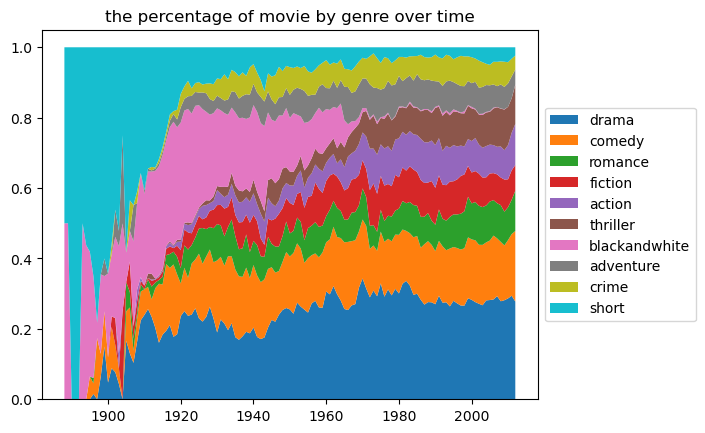

<AxesSubplot:title={'center':'the percentage of movie by genre over time'}>

In [11]:
percentage_df = grouped_by.copy()
percentage_df['sum'] = percentage_df.iloc[:, 1:11].sum(axis=1)
for genre in top_ten_genres:
    percentage_df[genre] = percentage_df[genre]/percentage_df['sum']

display(percentage_df.tail(5))
plot_stack_plot(percentage_df, top_ten_genres, years, "the percentage of movie by genre over time")

### Data Analysis Part 1 conclusion
* We can see that there is a sharp increase in the number of movies made since the 2000s
* Black and white movies almost disappeared completely after 1970s
* Short movies are less frequent 

## Data Analysis Part 2: Statistical tests, Genre vs Historical Events

In [12]:
from scipy import stats

def movies_by_genre_over_time(df, genre):
    """
    Get the number of movies with a particular genre for every year and the fraction
    number movies of genre / total number of movies (for a given year)

    returns: DataFrame (cols = [release_date, genre_count, total_count, fraction])
    """
    mask = df['genres'].apply(lambda x: genre in x)
    genre_df = df[mask]
    genre_df = genre_df.groupby(by='release_date').count()[['name']]
    genre_df = genre_df.rename(columns={'name': f'{genre}_count'})
    df2 = df.groupby(by='release_date').count()[['name']]
    genre_df['total_count'] = df2['name']
    genre_df['fraction'] = genre_df[f'{genre}_count'] / genre_df['total_count']
    return genre_df

def get_idx_from_date(df, event_year):
    """
    Returns the index for a year in the df received from the movies_by_genre_over_time-function
    """
    idx = 0
    for year in df.index.values:
        if year == event_year:
            return idx
        idx += 1
    return idx

def run_ttest_on_event(event, df : pd.DataFrame):
    """
    Runs a t-test comparing the fraction of movies made by genre BEFORE vs AFTER the event occured

    return: scipy.stats.ttest
    """
    date = event['date']
    if len(date) == 9:
        # The event was a range of years, e.g. from 1939-1945
        start_date = date.split('-')[0]
        end_date = date.split('-')[1]

        start_idx = get_idx_from_date(df, start_date)
        end_idx = get_idx_from_date(df, end_date)
        before_event = df.iloc[:start_idx]
        after_event = df.iloc[end_idx:]
    else:
        # The event was a single year 
        idx = get_idx_from_date(df, date)
        before_event = df.iloc[:idx]
        after_event = df.iloc[idx:]
    return stats.ttest_ind(before_event['fraction'], after_event['fraction'])

In [13]:
# Example usage of these functions. As we can see, there is a significant difference in the occurrences of "War film" after the World War II.
war_movie_df = movies_by_genre_over_time(movie_df, 'War film')
event = {'name': 'World War II', 'date': '1939-1945', 'link': 'https://en.wikipedia.org/wiki/World_War_II'}
run_ttest_on_event(event, war_movie_df)

Ttest_indResult(statistic=nan, pvalue=nan)

Now, lets run the analysis on all events (in AnnotatedListOfEvents.json) against all genres 

In [14]:
def convert_list_to_string(list_):
    string = ""
    for idx, e in enumerate(list_):
        if idx == len(list_)-1:
            string += str(e)
        else:
            string += str(e) + ", "
    return string

def get_all_unique_genres(df: pd.DataFrame) -> list:
    """
    returns all unique genres in the df
    """
    mydf = df.copy()
    mydf['genres'] = mydf['genres'].apply(lambda x: convert_list_to_string(x))
    genre_list = mydf['genres'].unique()
    genres = []
    for genre in genre_list:
        genre_list = genre.split(', ')
        for e in genre_list:
            genres.append(e)
    genres = list(set(genres))
    return genres

def filter_significant_tests(list_of_tests, alpha):
    """
    Returns a list of tests that is significant on significance level alpha
    """
    return [x for x in list_of_tests if x[2][1] < alpha]

# Run analysis 
genres = get_all_unique_genres(movie_df)
ttest_list = []
genre_dfs = []
for genre in genres:
    genre_dfs.append(movies_by_genre_over_time(movie_df, genre))
for event in event_data:
    for genre_df in genre_dfs:
        ttest = run_ttest_on_event(event, genre_df)
        ttest_list.append([event, str(genre_df.columns[0]).replace('_count', ''), ttest])

In [15]:
# Significance level alpha = 0.005
significant_ttests = filter_significant_tests(ttest_list, 0.005)
print("Number of tests done (Event vs Production of Genre Combinations):", len(ttest_list))
print("Number of significant (alpha = 0.005) increases / descreases after event:", len(significant_ttests))

Number of tests done (Event vs Production of Genre Combinations): 9100
Number of significant (alpha = 0.005) increases / descreases after event: 0


In [16]:
# TODO: might want to delete this one 
len(significant_ttests)
# TODO: this is stochastic, ie changing each time we run it, if we give example find one that only appears once eg

0

The cell above indicates that after "President Kennedy Is Assasinated" occured the production of the "Horror"-genre INCREASED, the p-value of this is: p ≈ 1.01e-16

In [17]:
# significant_ttests[10]

The cell above indicates that after "Albert Einstein's formulation of special relativity" occured the production of the "Silent film"-genre DECREASED, the p-value of this is: p ≈ 2.0e-5

### Comments

At the significance level $\alpha$ = 0.005, 1,512 out of 12,376 turned out "significant". But the exampel above suggests that there still are combinations in this set which doesn't make sense. The event of Albert Einstein publishing his work on special relativity propably didn't cause the genre "Silent film" to decrease. We treat the results from the t-tests above as an initial filter. Now we can do further analysis these combinations. The next step of the analysis will be to compare plot summaries of movies to Wikipedia summaries events. By doing this we might be able to see if there actually is any similarity between the historical event and movies that followed it. Example; the plot summaries of the "Silent films" that followed Einstein's discovery probabaly won't have anything to do with special relativity and we can rule them out.

## Data Analysis Part 3: Plot Summaries and Historical Events Similarity

In [18]:
%pip install gensim
%pip install nltk
%pip install stop_words

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
import pathlib
import multiprocessing

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to /home/leo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/leo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/leo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [19]:

import string
from stop_words import get_stop_words
from nltk.stem import WordNetLemmatizer

def apply_text_preprocessing(df : pd.DataFrame):
        # Create new df where we remove all rows with missing plots
        processed =  df[df['plot'].notna()]['plot'].values

        # Tokenize the each document 
        processed = [tokenize_doc(doc) for doc in processed]

        # Remove the stopwords
        processed = [remove_stopwords(doc) for doc in processed]

        # Apply lemmatization 
        processed = [lemmatize_doc(doc) for doc in processed]

        # Remove the words occuring in more than p of the documents
        # We use a low value since we want make events more distinct
        processed = remove_frequent_words(processed, 0.05)

        return processed


def tokenize_doc(doc):
        """
        Tokenizes a document 

        returns: list of tokens
        """
        # TODO: use insights from lectures about handling text and see if we can improve this pipeline
        tokenized = word_tokenize(
                doc
                # Remove certain special characters
                .replace('\n', '')
                .replace('\r', '')
                # Remove punctuation and special characters
                .translate(str.maketrans('', '', string.punctuation))
        )
        return tokenized

def remove_stopwords(doc):
        stop_words = get_stop_words('en')
        without_stopwords = []
        for word in doc: 
                # Add word to dict if it hasn't been added before 
                if word.lower() in stop_words: 
                        continue
                without_stopwords.append(word)
        return without_stopwords

def lemmatize_doc(doc):
        lemmatizer = WordNetLemmatizer()
        lemma = []
        for word in doc: 
                lemma.append(lemmatizer.lemmatize(word))
        return lemma

def remove_frequent_words(docs, p):
        """
        Removed words in doc occurring in p percent or more of document
        """
        # Create dictionary mapping word to doc_count in corpus
        count = {}
        for doc in docs:
                added_from_doc = {}
                for word in doc:
                        # Skip words already added 
                        if word in added_from_doc:
                                continue
                        added_from_doc[word] = 1 
                        # Add word to running count
                        if word in count: 
                                count[word] += 1
                        else: 
                                count[word] = 1
        # Iterate dictionary mappings and remove all those that occur less than p percent of corpus
        # freq_count contains words we should use 
        uniques = {}
        removed = {}
        for word, occurrences in count.items():
                if occurrences/len(docs) < p or word in uniques:
                        if not word in removed: 
                                uniques[word] = occurrences
                        else: 
                                uniques[word] += occurrences
                else:
                        if not word in removed: 
                                removed[word] = occurrences
                        else: 
                                removed[word] += occurrences

        print(f"Removed {len(removed.keys())} words since they appear more than {p*100}% of docs threshold")

        with open('removed5.txt', 'w') as file:
                file.write(json.dumps(removed))
        with open('uniques.txt', 'w') as file2:
                file2.write(json.dumps(uniques))
                
        # Iterate all words in all docs and remove those words that are in dict 
        filtered_docs = []
        for doc in docs:
                filtered_doc = []
                for word in doc: 
                        if word in uniques:
                                filtered_doc.append(word)
                filtered_docs.append(filtered_doc)
        return filtered_docs

def plot_cdf(df : pd.DataFrame):
        cdf = df.copy()
        cdf = df[df['plot'].notna()]['plot']
        cdf = df.groupby('release_date').count().sort_values('release_date').reset_index()
        cdf['movies_before'] = cdf['name'].cumsum()
        cdf['movies_before_percentage'] = cdf['movies_before'] / df.shape[0]
        cdf = cdf[['release_date', 'movies_before', 'movies_before_percentage']]
        cdf_1940 = cdf[cdf['release_date'] == 1940]
        # TODO: make graph prettier (do last thing so we synch all graph apperances) 
        plt.plot(cdf['release_date'], cdf['movies_before_percentage'])
        plt.xticks(np.arange(cdf['release_date'].min(), cdf['release_date'].max(), 10), rotation = 45) 
        plt.title('CDF of movies by release date')
        plt.show()
        print("In 1940, 3590 movies had been created, which is more than 9% of the total movies. This should be enough to do analysis, which motivates why we only look at events after 1940.")
        display(cdf_1940)

# test = pd.DataFrame(
#         {'plot': ["unique unique crazy bad", "unique one two", "unique two three"]}
# )

# Run text pre-processing pipeline
plot_removed = apply_text_preprocessing(
        data_clean_movies(orig_movie_df)
)

# Analyze the distributions of movies with plots 
# plot_cdf(plot_removed)

# Create TaggedDocuments 
tokenized_summaries = [TaggedDocument(doc, [idx]) for idx, doc in enumerate(plot_removed)]

Removed 374 words since they appear more than 5.0% of docs threshold


In [20]:
def create_doc2vec_model(documents, force_train_new = False):
    """
    Loads existing model from disk if available else trains new model.
    Set force_train_new to True to train a new model even if a previous model exists.
    
    returns: trained Doc2Vec model
    """

    fname = str(pathlib.Path().resolve()) + "/doc2vec_model"
    if not force_train_new:
        # Try to load, if it succeeds then previous model existed so return that one
        try:
            return Doc2Vec.load(fname)
        except:
            print("Failed to load existing model")

    # Train model
    print("Start training of Doc2Vec model...")
    model = Doc2Vec(
        documents, 
        window=2, 
        min_count=1, 
        workers=multiprocessing.cpu_count(), 
        epochs = 100
    )
    
    # Persist the model
    print(f"Finished training Doc2Vec, saving it to file {fname}")
    model.save(fname)
    return model

# Train the doc2vec model
model = create_doc2vec_model(tokenized_summaries, force_train_new=False)

In [114]:
%pip install wikipedia-api
import wikipediaapi
wiki_wiki = wikipediaapi.Wikipedia('en')


# Import all historical events
f = open('AnnotatedListOfEvents.json')
event_data = json.load(f)
event_data = event_data['events']
# Use the model to create a vectorized representation of the event text

# Compare the event vector against all vectors of the movie summaries and extract the top 10 most similar ones

# Create a df from this and merge with movie_df so we can get some movie information

movie_df = movie_df.reset_index(drop=True)
similarity_df = pd.DataFrame(columns=['name', 'similarity', 'release_date', 'event', "genres"])


def parseDocument(doc:str):
        # Create new df where   we remove all rows with missing plots
        # Tokenize the each document 
        processed = tokenize_doc(doc)
        processed = remove_stopwords(processed)
        processed = lemmatize_doc(processed)
        f = open('removed5.txt')
        removed_dict = json.load(f)
        for idx,word in enumerate(processed):
            if word in removed_dict:
                processed.remove(word)


        return processed

#Extract the n most similar movies to a certain event using similarity score from the doc2vec model
def extract_n_most_similar(subject, n):
    summary = wiki_wiki.page(subject).summary
    test_doc = parseDocument(summary)
    test_vector = model.infer_vector(test_doc)
    return model.dv.most_similar(positive=[test_vector],topn=n)


#Concatenate two dataframes
def merge_dataframes(df1, df2):
    pd_object = [df2, df1]
    return pd.concat(pd_object)


#Create a dataframe with the correct columns with input formated as a list of tuples [(movie_id, similarity_score)]
def create_event_similarity_df(subject, top_similar):
    top_similar_df = pd.DataFrame(top_similar, columns=["id", "similarity"]).set_index("id")
    top_similar_df['event'] = subject
    return pd.merge(top_similar_df, movie_df, left_index=True, right_index=True)[["name", "similarity", "release_date", "event", "genres"]]


def getDfWithThreshold(movie_df:pd.DataFrame, count, sim):
        return movie_df[movie_df["similarity"] > sim]
        return movie_df.sort_values(by = "similarity", ascending=False).head(count)

#Loop through all events and fill similarity dataframe with similar movies to each event.
subjects = [subject['link'] for subject in event_data]
for subject in subjects:
    top_similar = extract_n_most_similar(subject, 30000)
    top_similar_df = create_event_similarity_df(subject,top_similar)
    top_similar_df = getDfWithThreshold(top_similar_df,200, 0.4)

    similarity_df = merge_dataframes(similarity_df, top_similar_df)

similarity_df 

Note: you may need to restart the kernel to use updated packages.


,name,similarity,release_date,event,genres
24556,Rakkuyilin Ragasadassil,0.514847,1986,Negotiations_to_end_apartheid_in_South_Africa,[Drama]
7990,Anne of Green Gables,0.505184,1956,Negotiations_to_end_apartheid_in_South_Africa,[Musical]
23141,A Trick of Light,0.504053,1995,Negotiations_to_end_apartheid_in_South_Africa,"[Drama, World cinema]"
18053,María Morena,0.499942,1952,Negotiations_to_end_apartheid_in_South_Africa,"[Drama, Musical]"
39420,Sachai Ki Taqat,0.492806,1989,Negotiations_to_end_apartheid_in_South_Africa,"[Drama, Family Film]"
...,...,...,...,...,...
10385,Männer gegen Panzer,0.400274,1943,Attack_on_Pearl_Harbor,[Short Film]
19423,Azaad,0.400267,1978,Attack_on_Pearl_Harbor,[Thriller]
35145,Speed,0.400160,1922,Attack_on_Pearl_Harbor,"[Action, Adventure, Blackandwhite, Silent film]"
26996,The Panama Deception,0.400089,1989,Attack_on_Pearl_Harbor,"[Documentary, History, Indie, Social issues]"


In [115]:
def extract_event_dates(events):
        dates_df = pd.DataFrame(columns=['link', 'date', 'name'])
        dates_df.reset_index()
        for event in events:
                dates_df = dates_df.append({'link': event['link'], 'date': event['date'], 'name': event['name']}, ignore_index=True)

        dates_df.set_index(['link'], inplace=True)    
        return dates_df

dates_df = extract_event_dates(event_data)     

/tmp/ipykernel_33128/174215609.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dates_df = dates_df.append({'link': event['link'], 'date': event['date'], 'name': event['name']}, ignore_index=True)
/tmp/ipykernel_33128/174215609.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dates_df = dates_df.append({'link': event['link'], 'date': event['date'], 'name': event['name']}, ignore_index=True)
/tmp/ipykernel_33128/174215609.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dates_df = dates_df.append({'link': event['link'], 'date': event['date'], 'name': event['name']}, ignore_index=True)
/tmp/ipykernel_33128/174215609.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

In [116]:
similarity_df = similarity_df[similarity_df['release_date'] != 'nan']
similarity_df['release_date'] = similarity_df['release_date'].apply(lambda x : int(x))
movie_df['release_date'] = movie_df['release_date'].apply(lambda x : int(x))


#Check if the date_str has '-' in it -> events spans over several years. Example 1939-1945
def is_date_interval(date_str):
        return  '-' in date_str


#Extract the start date and end date from date_str
def extract_date_interval(date_str):
        date_interval = date_str.split("-")
        date_start = date_interval[0]
        date_end = date_interval[1]
        return int(date_start), int(date_end)


#create two dataframes splitted at a certain date
def sep_movies_at_event(movies_df, date_before, date_end):
        events_before = movies_df[movies_df["release_date"] < int(date_before)]
        events_after = movies_df[movies_df["release_date"] > int(date_end)]
        return events_before, events_after


#Create two dataframes splitted at a certain date, regarding to events possible spanning over several years
def get_df_before_after_date(df, event):
        date_string = dates_df.loc[event]['date']
        if is_date_interval(date_string):
                date_before, date_end = extract_date_interval(date_string)
                events_before, events_after = sep_movies_at_event(df, date_before, date_end)
                total_before,total_after = sep_movies_at_event(movie_df, date_before, date_end)
        else:
                events_before, events_after = sep_movies_at_event(df, date_string, date_string)
                total_before, total_after = sep_movies_at_event(movie_df, date_string, date_string)

        return [events_before, events_after, total_before, total_after]


#For each event, calculate fraction of movies created before and after an event. Ex. (movies related to the event before event occured / All movies made before event)
def get_fraction_for_event():
        fraction_df = pd.DataFrame(columns=['event', 'before_date_frac', 'after_date_frac'])
        for event in similarity_df['event'].unique():
                event_df = similarity_df[similarity_df["event"] == event]
                before_date, after_date, total_before, total_after = get_df_before_after_date(event_df, event)
                after_date_frac = after_date.size / (total_after.size)
                before_date_frac = before_date.size / (total_before.size)
                fraction_df = fraction_df.append({'event': event, 'before_date_frac': before_date_frac, 'after_date_frac': after_date_frac}, ignore_index=True)
        return fraction_df

#For each event, create a dataframe with ttests comparing means of similarity score, before and after an event
def get_ttest_df():
        ttest_df = pd.DataFrame(columns=['event', 'ttest'])
        for event in similarity_df['event'].unique():
                event_df = similarity_df[similarity_df["event"] == event]
                before_date, after_date, _, _ = get_df_before_after_date(event_df, event)
                if before_date.size == 0:
                        before_date = before_date.append({'event': event, 'similarity': 0}, ignore_index=True)
                if after_date.size == 0:
                        after_date = after_date.append({'event': event, 'similarity': 0}, ignore_index=True)
                ttest = stats.ttest_ind(before_date['similarity'], after_date['similarity'], equal_var=False)
                ttest_df = ttest_df.append({'event': event, 'ttest': ttest}, ignore_index=True)
        return ttest_df

In [117]:
import seaborn as sns

def boxplot_similarity_for_event(df: pd.DataFrame, event):
        event_df = df[df['event'] == event]
        before_df, after_df, _, _ = get_df_before_after_date(event_df, event)
        before_df['is_after'] = 0
        after_df['is_after'] = 1
        event_df = pd.concat([before_df, after_df])
        return sns.boxplot(data = event_df, y = 'similarity', x = 'is_after')

In [118]:
fraction_df = get_fraction_for_event()

/tmp/ipykernel_33128/3487458234.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fraction_df = fraction_df.append({'event': event, 'before_date_frac': before_date_frac, 'after_date_frac': after_date_frac}, ignore_index=True)
/tmp/ipykernel_33128/3487458234.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fraction_df = fraction_df.append({'event': event, 'before_date_frac': before_date_frac, 'after_date_frac': after_date_frac}, ignore_index=True)
/tmp/ipykernel_33128/3487458234.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fraction_df = fraction_df.append({'event': event, 'before_date_frac': before_date_frac, 'after_date_frac': after_date_frac}, ignore_index=True)
/tmp/ipykernel_33128/3487458234.py:48: FutureW

In [119]:
ttest_df = get_ttest_df()

                                           name  similarity  release_date  \
24556                   Rakkuyilin Ragasadassil    0.514847          1986   
7990                       Anne of Green Gables    0.505184          1956   
18053                              María Morena    0.499942          1952   
39420                           Sachai Ki Taqat    0.492806          1989   
15263                 The Door with Seven Locks    0.481509          1962   
...                                         ...         ...           ...   
1023                            Lost in Siberia    0.401483          1991   
18807                          The Silver Trail    0.401325          1937   
23337                    A Question of Adultery    0.401103          1958   
21037                  Parlor, Bedroom and Bath    0.400586          1931   
8689   Max Headroom: 20 Minutes into the Future    0.400016          1985   

                                               event  \
24556  Negotiations

/tmp/ipykernel_33128/3487458234.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({'event': event, 'ttest': ttest}, ignore_index=True)
/tmp/ipykernel_33128/3487458234.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({'event': event, 'ttest': ttest}, ignore_index=True)
/tmp/ipykernel_33128/3487458234.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({'event': event, 'ttest': ttest}, ignore_index=True)
/tmp/ipykernel_33128/3487458234.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({'event': event, 'ttest': ttest}, ign

                          name  similarity  release_date      event  \
19466                 Jet Pink    0.531709          1967  Apollo_13   
9150                Plane Nuts    0.497206          1933  Apollo_13   
27480  My Mother and Her Guest    0.494586          1961  Apollo_13   
10798      The Devil's Brother    0.492389          1933  Apollo_13   
34472        Masam Masam Manis    0.475120          1965  Apollo_13   
...                        ...         ...           ...        ...   
23305  The Avenging Conscience    0.403879          1914  Apollo_13   
17956      The Tale of a Shirt    0.403780          1922  Apollo_13   
17479         Law and Disorder    0.402804          1958  Apollo_13   
10942  We've Never Been Licked    0.402619          1943  Apollo_13   
35265        For Me and My Gal    0.401813          1942  Apollo_13   

                                                  genres  
19466                    [Animation, Comedy, Short Film]  
9150                         

/tmp/ipykernel_33128/3487458234.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({'event': event, 'ttest': ttest}, ignore_index=True)
/tmp/ipykernel_33128/3487458234.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({'event': event, 'ttest': ttest}, ignore_index=True)
/tmp/ipykernel_33128/3487458234.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({'event': event, 'ttest': ttest}, ignore_index=True)
/tmp/ipykernel_33128/3487458234.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({'event': event, 'ttest': ttest}, ign

                          name  similarity  release_date               event  \
2919    The Love of Jeanne Ney    0.550038          1927  Great_Leap_Forward   
26555        Invisible Stripes    0.490575          1939  Great_Leap_Forward   
35768                Dodsworth    0.464320          1936  Great_Leap_Forward   
11957    Toby Tortoise Returns    0.456835          1936  Great_Leap_Forward   
15942                 Miss Oyu    0.452465          1951  Great_Leap_Forward   
36591   The Education of Nicky    0.449172          1921  Great_Leap_Forward   
13705     Count Three and Pray    0.448528          1955  Great_Leap_Forward   
36934    The House on Trubnaya    0.448437          1928  Great_Leap_Forward   
29254       The House of Mirth    0.445329          1918  Great_Leap_Forward   
24659       Seeta Rama Jananam    0.443661          1944  Great_Leap_Forward   
2319               Nez de cuir    0.442388          1952  Great_Leap_Forward   
10338       Where Sinners Meet    0.4410

/tmp/ipykernel_33128/3487458234.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({'event': event, 'ttest': ttest}, ignore_index=True)
/tmp/ipykernel_33128/3487458234.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({'event': event, 'ttest': ttest}, ignore_index=True)
/tmp/ipykernel_33128/3487458234.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({'event': event, 'ttest': ttest}, ignore_index=True)
/tmp/ipykernel_33128/3487458234.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({'event': event, 'ttest': ttest}, ign

                            name  similarity  release_date     event  \
10341                       Gold    0.560221          1932  Cold_War   
11957      Toby Tortoise Returns    0.510932          1936  Cold_War   
31398                     Patria    0.504424          1917  Cold_War   
26193         Little Miss Marker    0.496921          1934  Cold_War   
8475              The Master Key    0.483162          1945  Cold_War   
...                          ...         ...           ...       ...   
29053      La Prise de Tournavos    0.403750          1897  Cold_War   
5                  The Gangsters    0.403050          1913  Cold_War   
10388  The Adventures of Kathlyn    0.402271          1913  Cold_War   
10932           Princess Tam Tam    0.400504          1935  Cold_War   
30795               Champi-Tortu    0.400370          1920  Cold_War   

                                                  genres  
10341                                          [Western]  
11957            

/tmp/ipykernel_33128/3487458234.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({'event': event, 'ttest': ttest}, ignore_index=True)
/tmp/ipykernel_33128/3487458234.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({'event': event, 'ttest': ttest}, ignore_index=True)
/tmp/ipykernel_33128/3487458234.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({'event': event, 'ttest': ttest}, ignore_index=True)


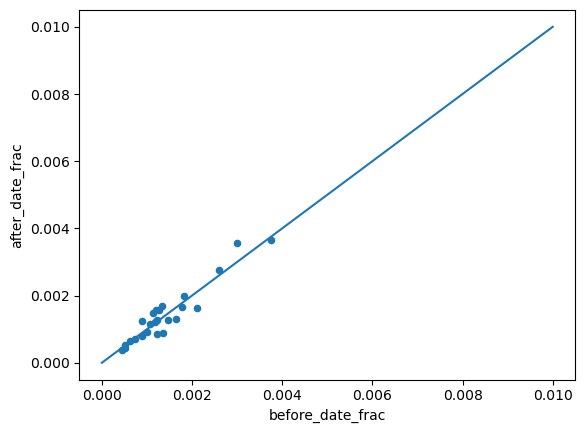

In [120]:
fraction_df.plot.scatter(x = 'before_date_frac', y = 'after_date_frac')
x = np.linspace(0, 0.01, 1000)
plt.plot(x, x)
plt.show()

In [121]:
def get_significant_ttests(df, alpha):
    significant_ttests_df = pd.DataFrame(columns = ['event', 'ttest'])
    for idx in range(len(df)):
        if df.iloc[idx]['ttest'].pvalue < alpha:
            significant_ttests_df = significant_ttests_df.append({'event': df.iloc[idx]['event'], 'ttest': df.iloc[idx]['ttest']}, ignore_index=True)
    return significant_ttests_df

significant_ttests_df = get_significant_ttests(ttest_df, 0.05)
print("Nbr of significant t-tests:", len(significant_ttests_df))
print("Nbr of t-tests", len(ttest_df))

Nbr of significant t-tests: 3
Nbr of t-tests 25


/tmp/ipykernel_33128/2350636035.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  significant_ttests_df = significant_ttests_df.append({'event': df.iloc[idx]['event'], 'ttest': df.iloc[idx]['ttest']}, ignore_index=True)
/tmp/ipykernel_33128/2350636035.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  significant_ttests_df = significant_ttests_df.append({'event': df.iloc[idx]['event'], 'ttest': df.iloc[idx]['ttest']}, ignore_index=True)
/tmp/ipykernel_33128/2350636035.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  significant_ttests_df = significant_ttests_df.append({'event': df.iloc[idx]['event'], 'ttest': df.iloc[idx]['ttest']}, ignore_index=True)


In [122]:
significant_ttests_df

,event,ttest
0,Negotiations_to_end_apartheid_in_South_Africa,"(-2.1555703214779833, 0.03274933157680756)"
1,Apollo_13,"(-2.372556141429607, 0.018731859088699787)"
2,Berlin_Wall,"(2.2811485434503695, 0.025233683867760884)"


In [123]:
def get_insignificant_ttests(df, alpha):
    significant_ttests_df = pd.DataFrame(columns = ['event', 'ttest'])
    for idx in range(len(df)):
        if df.iloc[idx]['ttest'].pvalue > alpha:
            significant_ttests_df = significant_ttests_df.append({'event': df.iloc[idx]['event'], 'ttest': df.iloc[idx]['ttest']}, ignore_index=True)
    return significant_ttests_df

insig_df = get_insignificant_ttests(ttest_df, 0.05)

/tmp/ipykernel_33128/110856643.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  significant_ttests_df = significant_ttests_df.append({'event': df.iloc[idx]['event'], 'ttest': df.iloc[idx]['ttest']}, ignore_index=True)
/tmp/ipykernel_33128/110856643.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  significant_ttests_df = significant_ttests_df.append({'event': df.iloc[idx]['event'], 'ttest': df.iloc[idx]['ttest']}, ignore_index=True)
/tmp/ipykernel_33128/110856643.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  significant_ttests_df = significant_ttests_df.append({'event': df.iloc[idx]['event'], 'ttest': df.iloc[idx]['ttest']}, ignore_index=True)
/tmp/ipykernel_33128/110856643.py:5: FutureWarning: The frame.append m

In [124]:
insig_df

,event,ttest
0,Nelson_Mandela,"(0.6180451914032472, 0.5371141196963027)"
1,Fall_of_the_Berlin_Wall,"(-1.042011860266406, 0.2987336797529412)"
2,Stanislav_Petrov,"(-1.5165260031086556, 0.130934911742812)"
3,Falklands_War,"(1.3505725756619082, 0.17888709398010966)"
4,Attempted_assassination_of_Ronald_Reagan#:~:te...,"(0.5453683828391687, 0.587593472319512)"
5,Iranian_Revolution#:~:text=Iranian%20people%20...,"(0.6542080339018547, 0.5135535742954687)"
6,Apollo_11,"(-0.36326456026209863, 0.7168966203104161)"
7,Death_and_state_funeral_of_Winston_Churchill,"(1.0720217527357203, 0.29125892283124294)"
8,Civil_Rights_Act_of_1964,"(-0.5819978287157489, 0.5615748209382982)"
9,Assassination_of_John_F._Kennedy,"(-1.5173073869982163, 0.13183029975814908)"


/tmp/ipykernel_33128/1637330228.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_df['is_after'] = 0
/tmp/ipykernel_33128/1637330228.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_df['is_after'] = 1


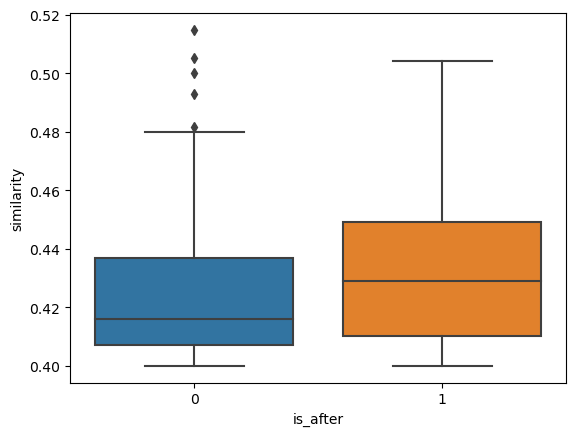

/tmp/ipykernel_33128/1637330228.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_df['is_after'] = 0
/tmp/ipykernel_33128/1637330228.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_df['is_after'] = 1


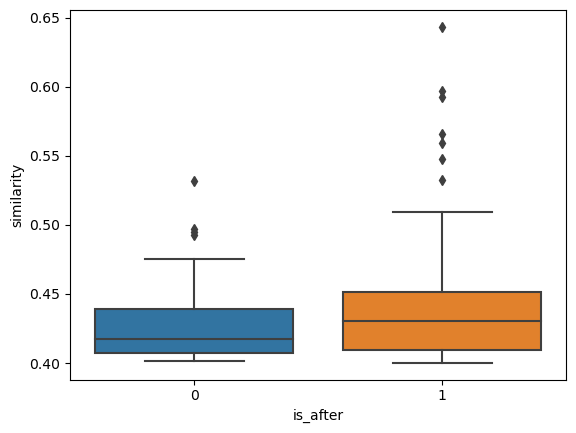

In [125]:
for idx, df_row in enumerate(significant_ttests_df):
    row, col = idx // 5, idx % 5
    ax = boxplot_similarity_for_event(similarity_df, event=significant_ttests_df.iloc[idx]['event'])
    plt.show()

### Comments
As expected, the top 10 movies are similar in terms of plot to the Apollo 13 event. With this proof-of-concept we have proved that it's possible to match movie plots to wikipedia summaries. We now have a great foundation to further develop our work, as outlined in the READ.ME.

#### Q2/
##### Does historical events affect the type of movies produced afterwards?
1. Do similarity score for all historical events and for each
2. Extract top 1000 most similar movies and 
3. do t-test for all categories only using these films as data

